In [1]:
import numpy as np
import matplotlib.pyplot as plt
import obspy.signal as signal
from obspy import read
import os
from glob import glob
import pandas as pd
import fnmatch
import math
import torch
from torch import nn
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchinfo import summary
import torch.nn.functional as F
import pyproj
import matplotlib
import obspy.signal.filter
from obspy.signal.trigger import classic_sta_lta, recursive_sta_lta
import datetime
from numpy.matlib import repmat
from time import time
import scipy
import obspy
import seaborn as sns
import matplotlib.gridspec as gridspec


## Fig 12 Histogram - find reliable predictions


#### This step was actually done after predicting the sources, re-ran the seismic modeling to extract the synthetic picks, and comparing the synthetic vs field picks

In [2]:
xcorr_min = np.load('data/field/meq_predictions/2012_2013/xcorr_min.npy')

## get the ones that are less than 500 ms
cri = np.where(xcorr_min<500)[0]
print(cri.shape)

(62,)


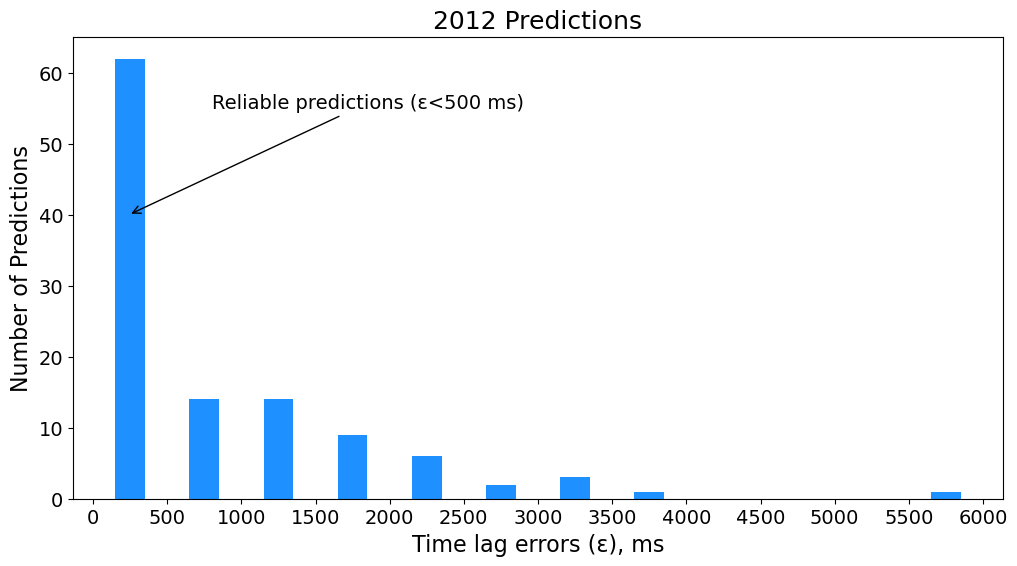

In [3]:
#All events XYZ
matplotlib.rcParams['xtick.labelsize']=14
matplotlib.rcParams['ytick.labelsize']=14

fig = plt.figure(figsize=(12,6))
ax = plt.gca()
ax.hist(xcorr_min,bins=np.arange(0,6500,500),rwidth=0.4,color='dodgerblue')
ax.set_xticks(np.arange(0, 6500, 500));
ax.set_xlabel('Time lag errors (ε), ms',fontsize=16)
ax.set_ylabel('Number of Predictions',fontsize=16)
ax.set_title('2012 Predictions',fontsize=18)
ax.annotate('Reliable predictions (ε<500 ms)',xy=(240,40),xytext=(800,55), arrowprops = dict(arrowstyle='->',facecolor ='black'),fontsize=14,color='black');
# plt.savefig('savefigs/12-timelag_losses_2012.jpg',bbox_inches='tight',dpi=300)



## Figure 13 - field predictions

In [4]:
## Load PMLP model
class MyModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 1000)
        self.fc2 = nn.Linear(1000, 200)
        self.fc3_mean = nn.Linear(200, 2)
        self.fc3_mean_depth = nn.Linear(200,1)
        self.fc3_log_std = nn.Linear(200, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mean_rest = self.fc3_mean(x)
        mean_depth = torch.relu(self.fc3_mean_depth(x))
        log_std = self.fc3_log_std(x)
        mean = torch.cat((mean_rest,mean_depth),axis=-1)

        return mean, log_std

## Prediction function
def predict(model, X, num_samples=1):
        with torch.no_grad():
            mean, log_std = model(X)
            std = torch.exp(log_std)
            
            # Sample from Gaussian distribution
            samples = torch.randn((num_samples, *mean.shape), device=mean.device) * std + mean
            
            # Return the average of samples
            return torch.mean(samples, dim=0)
        
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"); print(device); print(torch.cuda.get_device_name())

def to_np(arr):
    return arr.detach().cpu().numpy()



cuda:0
NVIDIA GeForce RTX 4080


In [9]:
## Load weights here 
#### There will be tiny variations in the results due to probabilistic nature

PMLP_model = MyModel(8,3).to(device).double()
PMLP_model.load_state_dict(torch.load('weights_logs/GoodRun_Combined_LV.pth')) 

<All keys matched successfully>

In [10]:
#### Load files
Best_Field_Picks = np.load('data/field/meq_waveforms/2012_2013_Processed_Selected/Best_Field_Picks.npy')

#Compute cross correlations and apply deep learning
all_field_1stArr_waveform = []
all_field_xcorr_waveform = []
all_field_prediction_loc = []
all_field_loc_ones = []
all_field_timelag = []
dt = 0.004
np.random.seed(155)

for event_i in tqdm(range(len(Best_Field_Picks))):

    #get matching first arrival convert into waveform
    event_arr_trigger = Best_Field_Picks[event_i]
    #make delta
    delta_arr = np.zeros((8,4000))
    for i in range(8):
        get_trig_idx = event_arr_trigger[i]
        delta_arr[i,get_trig_idx]=1
    all_field_1stArr_waveform.append(delta_arr)

    #compute cross correlation
    sample_field_xcorr = []
    master_tr = delta_arr[2].copy()
    for i in range(8):
        dat = np.correlate(master_tr,delta_arr[i],'same')
        sample_field_xcorr.append(dat)
    sample_field_xcorr_np = np.array(sample_field_xcorr)
    #crop sides so that length is from 10000 to 1024
    all_field_xcorr_waveform.append(sample_field_xcorr_np)

    #extract where ones
    loc_one = []
    for i in range(8):
        sample = sample_field_xcorr_np[i]
        loc = np.where(sample==1)[0][0]
        loc_one.append(loc)
    loc_one = np.array(loc_one)
    all_field_loc_ones.append(loc_one)

    #convert location of ones to time lag in terms of *dt
    timelag_arr = loc_one-2000
    timelag_arr = timelag_arr*dt
    all_field_timelag.append(timelag_arr)
    # #convert to torch
    sample_field_time_lag= torch.tensor(timelag_arr)[None,:].to(device).double()

    #Prediction
    with torch.no_grad():
        PMLP_model.eval()
        ypred_test = predict(PMLP_model,sample_field_time_lag,num_samples=2000)
        ypred_test_np = np.squeeze(to_np(ypred_test))
        #put in array
        all_field_prediction_loc.append(ypred_test_np)


all_field_1stArr_waveform = np.array(all_field_1stArr_waveform)
all_field_xcorr_waveform = np.array(all_field_xcorr_waveform)
all_field_prediction_loc = np.squeeze(np.array(all_field_prediction_loc))
all_field_timelag = np.squeeze(np.array(all_field_timelag))


100%|██████████| 113/113 [00:01<00:00, 91.37it/s]


In [11]:
## Compute the one less than critieria, again, cri was computed after rerunning seismic modeling based on all_field_prediction_loc, compute the forward modeled picks, and compute the loss between synthetic vs field picks.
cri_best_field_picks = Best_Field_Picks[cri]
cri_prediction_loc = all_field_prediction_loc[cri]

Best_PredFwd_FAs = np.load('data/field/meq_predictions/2012_2013/Best_PredFwd_FAs.npy')
cri_best_predfwd_FAs = Best_PredFwd_FAs[cri]

print(cri_best_field_picks.shape)
print(cri_prediction_loc.shape)
print(cri_best_predfwd_FAs.shape)


(62, 8)
(62, 3)
(62, 8)


(3,)


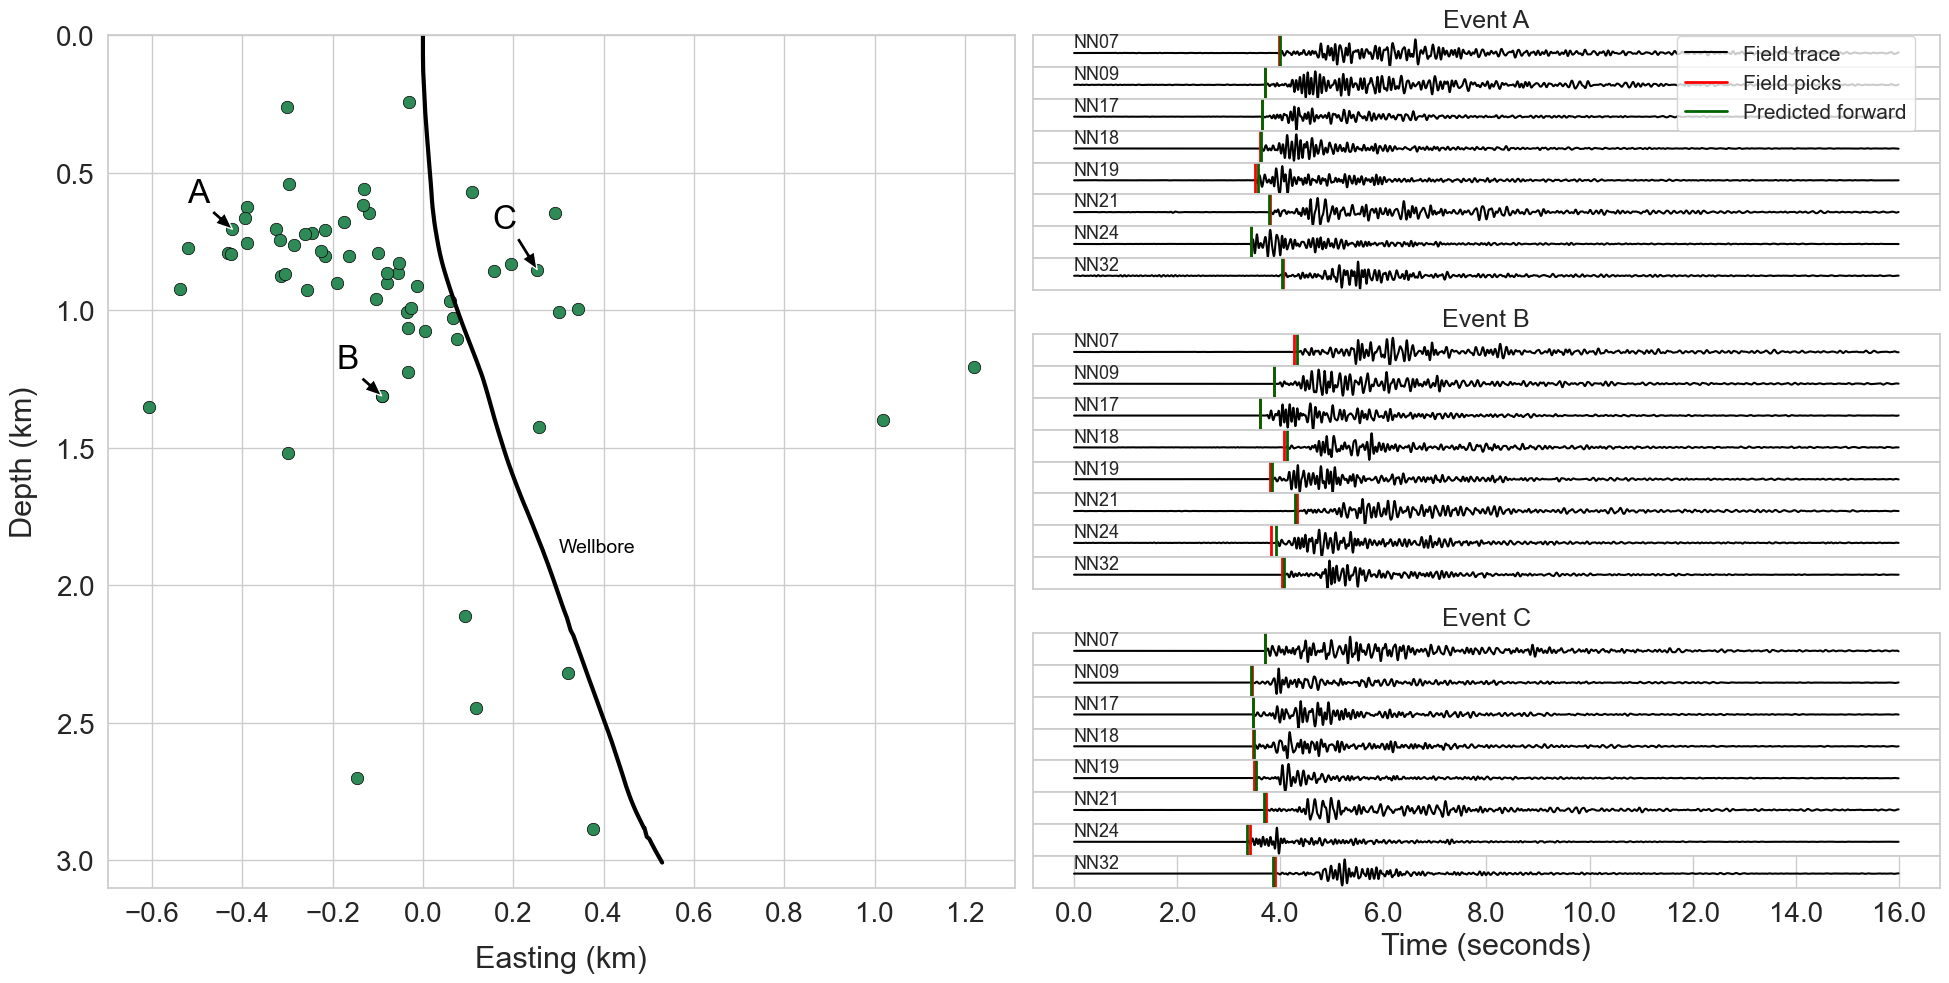

In [12]:
#seaborn team
sns.set_theme(style="whitegrid")
#matplotlib params
matplotlib.rcParams['xtick.labelsize']=20
matplotlib.rcParams['ytick.labelsize']=20
###### Initiate Figure here ######
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

######################################################## 2D prediction ##################################################

#wellbore
wb_coordinates = np.load('data/wellbore/wb_loc.npy')
wellhead = wb_coordinates[0]
wellhead_all = np.tile(wellhead,(96,1)); print(wellhead.shape)
wellhead_all[:,2] = 0
norm_wb_coordinates = wb_coordinates - wellhead_all

#### Plotting here
ax = plt.subplot(gs[:, 0])
ax.plot(norm_wb_coordinates[:,0]/1000,norm_wb_coordinates[:,2]/1000, linewidth=3,color='black')
ax.text(0.3,1.88,'Wellbore',fontsize=14,color='black');

#predicted locations (relocated)
ax.scatter(cri_prediction_loc[:,0]-wellhead[0]/1000,cri_prediction_loc[:,2], c='seagreen', s=80,edgecolors='black',linewidth=0.5)
### Annotate selected ones
gi = 31
pt = (cri_prediction_loc[gi,0]-wellhead[0]/1000,cri_prediction_loc[gi,2])
ax.annotate('A',xy=pt,xytext=(pt[0]-0.1,pt[1]-0.1),arrowprops = dict(facecolor ='black',width=3,headwidth=10),fontsize=24,color='black')
gi = 36
pt = (cri_prediction_loc[gi,0]-wellhead[0]/1000,cri_prediction_loc[gi,2])
ax.annotate('B',xy=pt,xytext=(pt[0]-0.1,pt[1]-0.1),arrowprops = dict(facecolor ='black',width=3,headwidth=10),fontsize=24,color='black')
gi = 9
pt = (cri_prediction_loc[gi,0]-wellhead[0]/1000,cri_prediction_loc[gi,2])
ax.annotate('C',xy=pt,xytext=(pt[0]-0.1,pt[1]-0.15),arrowprops = dict(facecolor ='black',width=3,headwidth=10),fontsize=24,color='black')

## axis labels
ax.set_xlabel('Easting (km)', fontsize=22,labelpad=13)
ax.set_ylabel('Depth (km)', fontsize=22,labelpad=13)
ax.set_ylim(0.0, 3.1)
ax.invert_yaxis()
xticks = np.arange(-0.6,1.4,0.2)
ax.set_xticks(xticks)

######################################################## Data Match ##################################################
#Load some ddata
all_field_BH = np.load('data/field/meq_waveforms/2012_2013_Processed_Selected/waveforms_2012_2013.npy')
cri_field_BH = all_field_BH[cri]

#load labeling info
all_stationIDs = ['NM03', 'NM06', 'NM08', 'NM22', 'NM40', 'NM41', 'NM42', 'NN07', 'NN09', 'NN17', 'NN18', 'NN19', 'NN21', 'NN24', 'NN32']
all_stationIDs_selected = all_stationIDs[-8:]
good_eventID_list = np.load('data/field/meq_waveforms/2014_Processed_Selected/waveforms_eventIDs.npy')
cri_eventID_list = good_eventID_list[cri]

### use 9, 31, 36
for i,cri_event_i in enumerate([9,31,36]):
    
    eventID = cri_eventID_list[cri_event_i]
    field_picks = cri_best_field_picks[cri_event_i]
    pred_fwd_FA = cri_best_predfwd_FAs[cri_event_i]
    diff = abs(pred_fwd_FA[2]-field_picks[2])
    predfwd_accordance = pred_fwd_FA+diff

    ##cut here to certain length
    length = 4000
    plen = 4000
    field_trace = cri_field_BH[cri_event_i,:,int((length-plen)/2) : int(length-(length-plen)/2)]
    field_picks_cut = field_picks-int((length-plen)/2)
    pred_forw_picks = predfwd_accordance-int((length-plen)/2)

    ### nested subplots
    ax_main = plt.subplot(gs[i, 1])  # main axes
    ax_main.set_xticks([])  # remove x axis
    ax_main.set_yticks([])  # remove y axis
    ax_main.spines['left'].set_color('none')  # remove boundary
    ax_main.spines['right'].set_color('none')
    ax_main.spines['bottom'].set_color('none')
    ax_main.spines['top'].set_color('none')

    # create 8 subplots within the main axes
    gs_sub = gridspec.GridSpecFromSubplotSpec(8, 1, subplot_spec=gs[i, 1], hspace=0.0)
    for j in range(8):
        ax_sub = plt.subplot(gs_sub[j, 0])
        #get all station ID
        stationID = all_stationIDs_selected[j]
        #plot field data
        ax_sub.plot(field_trace[j],color='black')
        ax_sub.text(0.02,0.4,'{}'.format(stationID),fontsize=13)
        ax_sub.set_ylim(-1,1.25)
        # plot trigger
        ax_sub.axvline(field_picks_cut[j],color='red',linewidth=2)
        # plot predicted forward
        ax_sub.axvline(pred_forw_picks[j],color='darkgreen',linewidth=2)
        #title
        if j == 0:
            ax_sub.set_title('Event {}'.format(chr(i+65)),fontsize=18)
        if j == 7 and i == 2:
            dt = 0.004
            xticks = np.arange(0,plen+500,500)
            xticks_label = np.round(xticks*dt,3)
            ax_sub.set_xticks(xticks)
            ax_sub.set_xticklabels(xticks_label,fontsize=20)
            ax_sub.set_xlabel('Time (seconds)',fontsize=22)
        else:
            ax_sub.set_xticks([])  # This line will remove the xticks from the subplots except the last row of Event C

        ax_sub.set_yticks([])
    if i==0:
        plt.legend(['Field trace','Field picks','Predicted forward'],fontsize=15,loc=(0.71,5))

fig.tight_layout()
plt.savefig('figures/13-2012_FieldPred_Combined.jpg',bbox_inches='tight',dpi=300)
